### Домашнее задание

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

from lightgbm import LGBMClassifier

# from catboost import CatBoostClassifier

# from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline, make_pipeline, FeatureUnion

from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import precision_recall_curve, roc_curve, roc_auc_score, confusion_matrix, log_loss
import itertools

In [2]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

1. обучить несколько разных моделей на наборе данных ССЗ (train_case2.csv): логрег, бустинг, лес и т.д - на ваш выбор 2-3 варианта
2. при обучении моделей обязательно использовать кроссвалидацию
3. вывести сравнение полученных моделей по основным метрикам классификации: pr/rec/auc/f_score (можно в виде таблицы, где строки - модели, а столбцы - метрики)
4. сделать выводы о том, какая модель справилась с задачей лучше других
5. (опциональный вопрос) какая метрика (precision_recall_curve или roc_auc_curve) больше подходит в случае сильного дисбаланса классов? (когда объектов одного из классов намного больше чем другого). 

p.s.В вопросе проще разобраться, если вспомнить оси на графике roc auc curve и рассмотреть такой пример:

Имеется 100000 объектов, из которых только 100 - класс "1" (99900 - класс "0", соответственно). 
Допустим, у нас две модели:

- первая помечает 100 объектов как класс 1, но TP = 90
- вторая помечает 1000 объектов как класс 1, но TP такой же - 90

Какая модель лучше и почему? И что позволяет легче сделать вывод - roc_auc_curve или precision_recall_curve?

In [3]:
df = pd.read_csv('train_case2.csv', delimiter=';')
df.head()

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,2,18857,1,165,64.0,130,70,3,1,0,0,0,1
3,3,17623,2,169,82.0,150,100,1,1,0,0,1,1
4,4,17474,1,156,56.0,100,60,1,1,0,0,0,0


In [4]:
print(df.shape)
df.describe()

(70000, 13)


,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
count,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000
mean,49972.419900,19468.865814,1.349571,164.359229,74.205690,128.817286,96.630414,1.366871,1.226457,0.088129,0.053771,0.803729,0.499700
std,28851.302323,2467.251667,0.476838,8.210126,14.395757,154.011419,188.472530,0.680250,0.572270,0.283484,0.225568,0.397179,0.500003
min,0.000000,10798.000000,1.000000,55.000000,10.000000,-150.000000,-70.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,25006.750000,17664.000000,1.000000,159.000000,65.000000,120.000000,80.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000
50%,50001.500000,19703.000000,1.000000,165.000000,72.000000,120.000000,80.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000
75%,74889.250000,21327.000000,2.000000,170.000000,82.000000,140.000000,90.000000,2.000000,1.000000,0.000000,0.000000,1.000000,1.000000
max,99999.000000,23713.000000,2.000000,250.000000,200.000000,16020.000000,11000.000000,3.000000,3.000000,1.000000,1.000000,1.000000,1.000000


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70000 entries, 0 to 69999
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   id           70000 non-null  int64  
 1   age          70000 non-null  int64  
 2   gender       70000 non-null  int64  
 3   height       70000 non-null  int64  
 4   weight       70000 non-null  float64
 5   ap_hi        70000 non-null  int64  
 6   ap_lo        70000 non-null  int64  
 7   cholesterol  70000 non-null  int64  
 8   gluc         70000 non-null  int64  
 9   smoke        70000 non-null  int64  
 10  alco         70000 non-null  int64  
 11  active       70000 non-null  int64  
 12  cardio       70000 non-null  int64  
dtypes: float64(1), int64(12)
memory usage: 6.9 MB


In [6]:
X = df.drop('cardio', axis=1)
y = df['cardio']

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [8]:
class ColumnSelector(BaseEstimator, TransformerMixin):
    """
    Transformer to select a single column from the data frame to perform additional transformations on
    """
    def __init__(self, key):
        self.key = key
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        return X[self.key]
    
class NumberSelector(BaseEstimator, TransformerMixin):
    """
    Transformer to select a single column from the data frame to perform additional transformations on
    Use on numeric columns in the data
    """
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[[self.key]]
    
class OHEEncoder(BaseEstimator, TransformerMixin):
    
    def __init__(self, key):
        self.key = key
        self.columns = []
        
    def fit(self, X, y=None):
        self.columns = [col for col in pd.get_dummies(X, prefix=self.key).columns]
        return self
    
    def transform(self, X):
        X = pd.get_dummies(X, prefix=self.key)
        test_columns = [col for col in X.columns]
        
        for col_ in test_columns:
            if col_ not in self.columns:
                X[col_] = 0
                
        return X[self.columns]

In [9]:
continuos_cols = ['age', 'height', 'weight', 'ap_hi', 'ap_lo']
cat_cols = ['gender', 'cholesterol']
base_cols = ['gluc', 'smoke', 'alco', 'active']

continuos_transformers = []
cat_transformers = []
base_transformers = []

for cont_col in continuos_cols:
    transfomer =  Pipeline([
                ('selector', NumberSelector(key=cont_col)),
                ('standard', StandardScaler())
            ])
    continuos_transformers.append((cont_col, transfomer))
    
for cat_col in cat_cols:
    cat_transformer = Pipeline([
                ('selector', ColumnSelector(key=cat_col)),
                ('ohe', OHEEncoder(key=cat_col))
            ])
    cat_transformers.append((cat_col, cat_transformer))
    
for base_col in base_cols:
    base_transformer = Pipeline([
                ('selector', NumberSelector(key=base_col))
            ])
    base_transformers.append((base_col, base_transformer))

In [10]:
feats = FeatureUnion(continuos_transformers+cat_transformers+base_transformers)
feature_processing = Pipeline([('feats', feats)])

feature_processing.fit_transform(X_train)

array([[ 0.09144178,  0.44594423,  0.05752649, ...,  0.        ,
         0.        ,  1.        ],
       [ 0.46216539,  0.20194394, -0.84752919, ...,  0.        ,
         0.        ,  1.        ],
       [ 1.5702846 , -1.01805752,  1.79801819, ...,  0.        ,
         0.        ,  1.        ],
       ...,
       [ 1.67238553,  0.56794437, -0.01209318, ...,  0.        ,
         0.        ,  1.        ],
       [-0.50009534,  0.32394408, -0.29057185, ...,  0.        ,
         0.        ,  0.        ],
       [-1.76136594,  1.54394554, -0.70828985, ...,  0.        ,
         0.        ,  1.        ]])

In [11]:
classifier = Pipeline([
    ('features',feats),
    ('classifier', LogisticRegression(random_state = 42)),
])

lgbm_classifier = Pipeline([
    ('features', feats),
    ('lgbm', LGBMClassifier(random_state=42))
])



#запустим кросс-валидацию
cv_scores = cross_val_score(classifier, X_train, y_train, cv=16, scoring='roc_auc')
cv_score = np.mean(cv_scores)
cv_score_std = np.std(cv_scores)
print('CV log_reg score is {}+-{}'.format(cv_score, cv_score_std))

cv_scores_lgbm = cross_val_score(lgbm_classifier, X_train, y_train, cv=16, scoring='roc_auc')
cv_score_lgbm = np.mean(cv_scores_lgbm)
cv_score_lgbm_std = np.std(cv_scores_lgbm)
print('CV lgbm score is {}+-{}'.format(cv_score_lgbm, cv_score_lgbm_std))

#обучим пайплайн на всем тренировочном датасете
classifier.fit(X_train, y_train)
y_score_log_reg = classifier.predict_proba(X_test)[:, 1]

CV log_reg score is 0.7821358976691873+-0.009748562688833385
CV lgbm score is 0.8025016770871312+-0.00848546582894907


In [12]:
k_neighbors_classifier = Pipeline([
    ('features', feats),
    ('k_neighbors_classifier', KNeighborsClassifier())
])

cv_scores_k_neighbors = cross_val_score(k_neighbors_classifier, X_train, y_train, cv=16, scoring='roc_auc')
cv_score_k_neighbors = np.mean(cv_scores_k_neighbors)
cv_score_k_neighbors_std = np.std(cv_scores_k_neighbors)
print('CV lgbm score is {}+-{}'.format(cv_score_k_neighbors, cv_score_k_neighbors_std))

CV lgbm score is 0.6914891433542698+-0.008874986081155906


In [13]:
lgbm_classifier.fit(X_train, y_train)
y_score_lgbm = lgbm_classifier.predict_proba(X_test)[:, 1]

In [14]:
k_neighbors_classifier.fit(X_train, y_train)
y_score_k_neighbors = k_neighbors_classifier.predict_proba(X_test)[:, 1]

In [15]:
def best_metrics(y_test, y_score, b=1):

    precision, recall, thresholds = precision_recall_curve(y_test.values, y_score)
    fscore = (1+b**2)*(precision * recall) / (b**2*precision + recall)
    # locate the index of the largest f score
    ix = np.argmax(fscore)
    print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix], 
                                                                        fscore[ix],
                                                                        precision[ix],
                                                                        recall[ix]))
    
    return thresholds[ix], fscore[ix], precision[ix], recall[ix]

In [16]:
models_metrics = []

### Модель логистической регрессии

In [17]:
threshold_log_reg, fscore_log_reg, precision_log_reg, recall_log_reg = best_metrics(y_test, y_score_log_reg)
models_metrics.append([threshold_log_reg, fscore_log_reg, precision_log_reg, recall_log_reg])

Best Threshold=0.397109, F-Score=0.735, Precision=0.656, Recall=0.837


In [18]:
def roc_auc_plot(y_t, y_s):
    sns.set(font_scale=1.5)
    sns.set_color_codes("muted")

    plt.figure(figsize=(10, 8))
    fpr, tpr, thresholds_ = roc_curve(y_t, y_s, pos_label=1)
    lw = 2
    plt.plot(fpr, tpr, lw=lw, label='ROC curve ')
    plt.plot([0, 1], [0, 1])
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC curve')
    plt.savefig("ROC.png")
    plt.show()

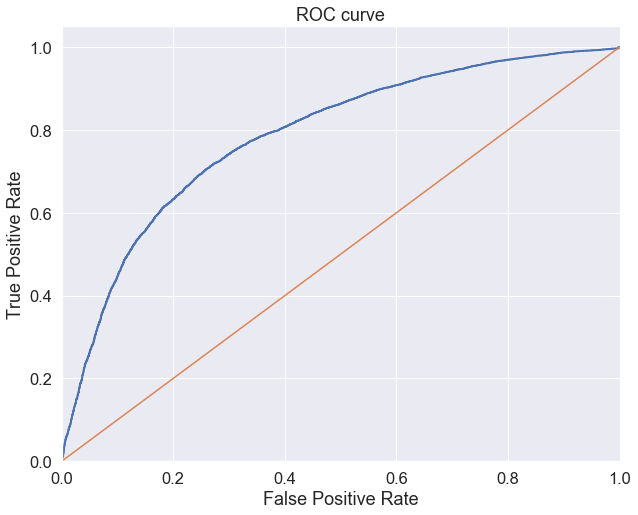

In [19]:
roc_auc_plot(y_test, y_score_log_reg)

In [20]:
print("roc auc score: {}".format(roc_auc_score(y_true=y_test, y_score=classifier.predict_proba(X_test)[:,1])))
print("log loss score: {}".format(log_loss(y_true=y_test, y_pred=classifier.predict_proba(X_test)[:,1])))

roc auc score: 0.7852393986644697
log loss score: 0.5758512545287223


Confusion matrix, without normalization
[[4810 3878]
 [1433 7379]]


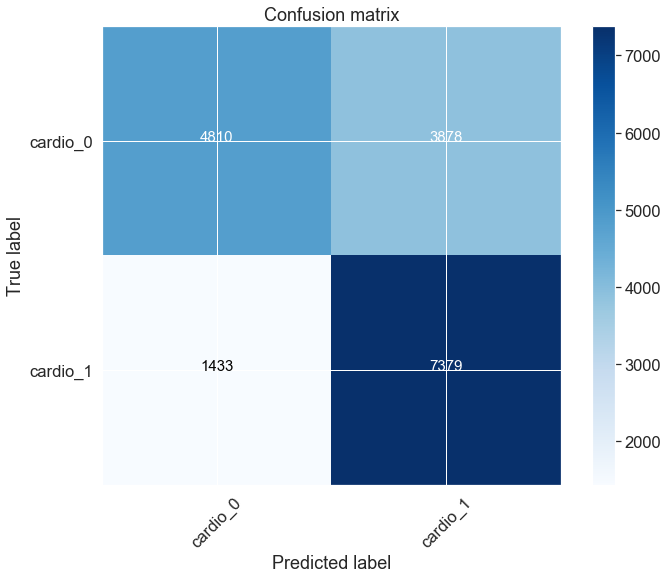

In [21]:
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix = confusion_matrix(y_test, y_score_log_reg>threshold_log_reg)
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['cardio_0', 'cardio_1'], title='Confusion matrix')
plt.show()

### Модель LightGB

In [22]:
threshold_lgbm, fscore_lgbm, precision_lgbm, recall_lgbm = best_metrics(y_test, y_score_lgbm)
models_metrics.append([threshold_lgbm, fscore_lgbm, precision_lgbm, recall_lgbm])

Best Threshold=0.407260, F-Score=0.746, Precision=0.709, Recall=0.787


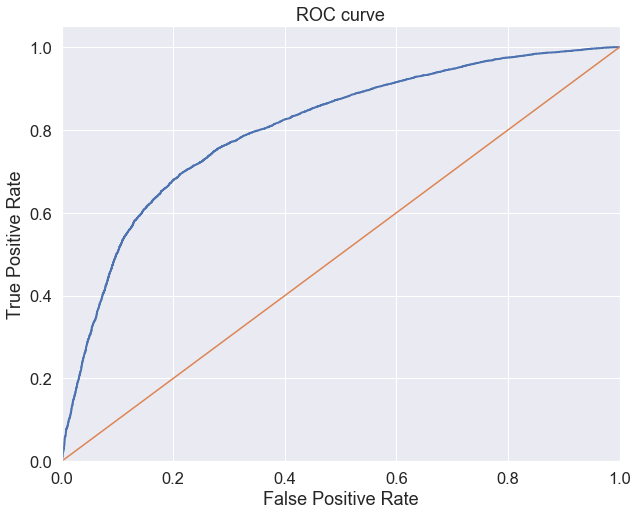

In [23]:
roc_auc_plot(y_test, y_score_lgbm)

Confusion matrix, without normalization
[[5846 2842]
 [1881 6931]]


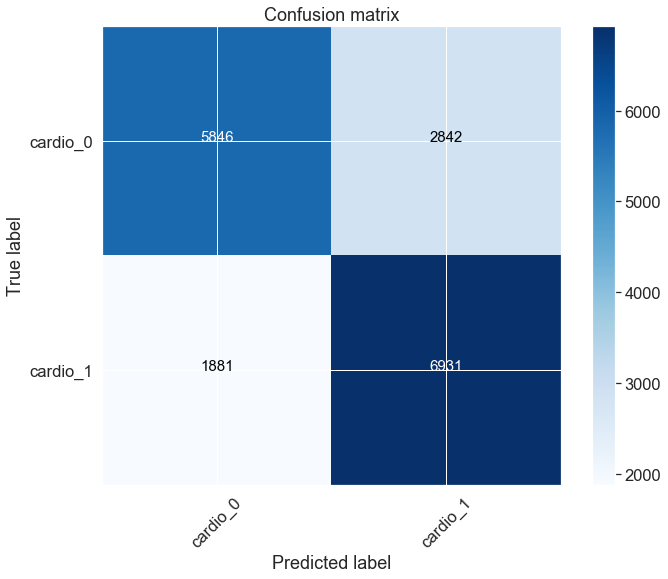

In [24]:
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix = confusion_matrix(y_test, y_score_lgbm>threshold_lgbm)
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['cardio_0', 'cardio_1'], title='Confusion matrix')
plt.show()

### Модель KNeighborsClassifier

In [25]:
threshold_k_neighbors, fscore_k_neighbors, precision_k_neighbors, recall_k_neighbors = best_metrics(y_test, y_score_k_neighbors)
models_metrics.append([threshold_k_neighbors, fscore_k_neighbors, precision_k_neighbors, recall_k_neighbors])

Best Threshold=0.400000, F-Score=0.691, Precision=0.592, Recall=0.831


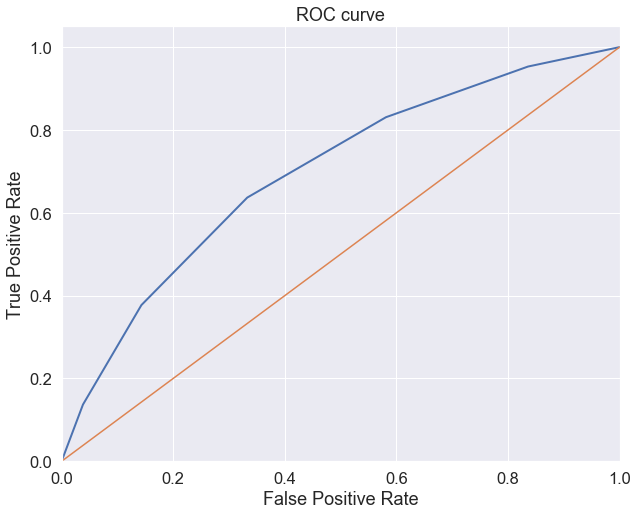

In [27]:
roc_auc_plot(y_test, y_score_k_neighbors)

Confusion matrix, without normalization
[[5797 2891]
 [3201 5611]]


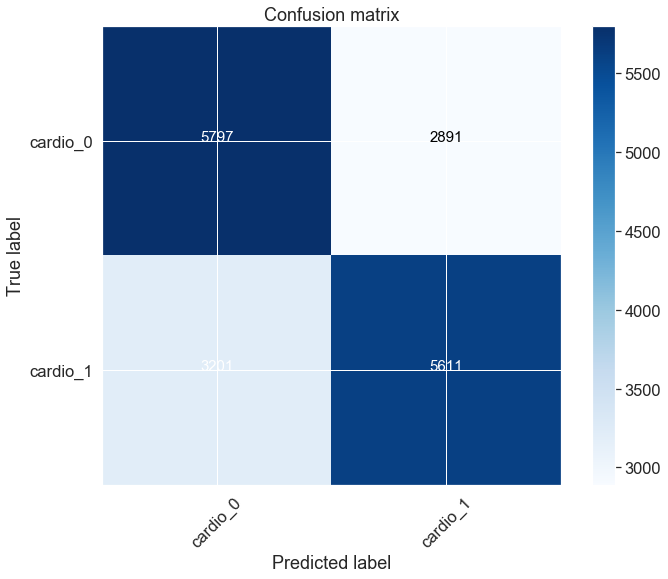

In [29]:
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix = confusion_matrix(y_test, y_score_k_neighbors>threshold_k_neighbors)
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['cardio_0', 'cardio_1'], title='Confusion matrix')
plt.show()

In [33]:
df_models_metrics = pd.DataFrame(models_metrics, 
                                 index=['logigtic_reg', 'light_gb', 'k_neighbors'], 
                                 columns=['threshold', 'fscore', 'precision', 'recall'])
df_models_metrics

,threshold,fscore,precision,recall
logigtic_reg,0.397109,0.735426,0.655534,0.837494
light_gb,0.407260,0.745938,0.709229,0.786655
k_neighbors,0.400000,0.691182,0.591739,0.830799


### 4. сделать выводы о том, какая модель справилась с задачей лучше других

По-моему лучше с задачей справилась логистическая регрессия, т.к. намного менше ошибается когда относит людей с сердечно-сосудистым заболеванем к здоровым. 